# Example 3 - Langmuir Hinshelwood mechanism

In this example, we will show how to build a Gaussian Process (GP) surrogate model for a Langmuir Hinshelwood (LH) mechanism and locate its optimum via Bayesian Optimization. 
In a typical LH mechanism, two molecules adsorb on neighboring sites and the adsorbed molecules undergo a bimolecular reaction:
$$ A + * ⇌ A* $$
$$ B + * ⇌ B* $$
$$ A* + B*  → Product $$

The reation rate can be expressed as,
$$ rate = \frac{k_{rds} K_1 K_2 P_A P_B}{(1 + K_1 P_A + K_2 P_B)^2}$$
where $k_{rds}$, $K_1$ and $K_2$ are the kinetic constants. $P_A$ and $P_B$ are the partial pressure of two reacting species. 
Here $P_A$ and $P_B$ are the independent variables `X1` and `X2`. The rate is the dependent variable `Y`. 
The goal is to determine the $P_A$ and $P_B$ value where the rate is maximized. 

The details of this example is summarized in the table below:

| Key Item      | Description |
| :----------------- | :---------------------------- |
| Goal | Maximization |
| Objective function | LH mechanism |
| Input (X) dimension | 2 |
| Output (Y) dimension | 1 |
| Analytical form available? | Yes |
| Acqucision function | Expected improvement (EI) |
| Initial Sampling | Full factorial or latin hypercube | 

Next, we will go through each step in Bayesian Optimization.


## 1. Import `nextorch` and other packages

In [11]:
import os
import sys
project_path = os.path.abspath(os.path.join(os.getcwd(), '..\..'))
sys.path.insert(0, project_path)

import numpy as np
from nextorch import plotting, bo, doe

## 2. Define the objective function and the design space
We use a Python function `rate` as the objective function `objective_func`. 

The range of the input $P_A$ and $P_B$ is between 1 and 10 bar. 

In [2]:
#%% Define the objective function
def rate(P): 
    """langmuir hinshelwood mechanism

    Parameters
    ----------
    P : numpy matrix
        Pressure of species A and B
        2D independent variable

    Returns
    -------
    r: numpy array
        Reactio rate, 1D dependent variable
    """
    # kinetic constants
    K1 = 1
    K2 = 10
    
    krds = 100
    
    # Expend P to 2d matrix
    if len(P.shape) < 2:
        P = np.array([P])
        
    r = np.zeros(P.shape[0])

    for i in range(P.shape[0]):
        P_A, P_B = P[i][0], P[i][1]
        r[i] = krds*K1*K2*P_A*P_B/((1+K1*P_A+K2*P_B)**2)
    
    # Put y in a column
    r = np.expand_dims(r, axis=1)
    
    return r

# Objective function
objective_func = rate

# Set the ranges
X_ranges = [[1, 10], [1, 10]]


## 3. Define the initial sampling plan
Here we compare two sampling plans with the same number of sampling points:

1. Full factorial (FF) design with levels of 5 and 25 points in total. 
2. Latin hypercube (LHC) design with 10 initial sampling points, and 15 more Bayesian Optimization trials

The initial reponse in a real scale `Y_init_real` is computed from the helper function `bo.eval_objective_func(X_init, X_ranges, objective_func)`, given `X_init` in unit scales.

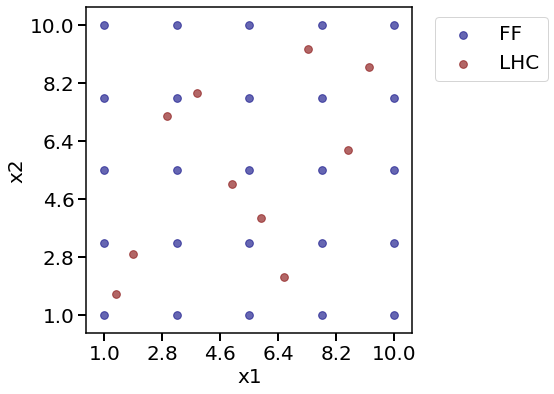

In [3]:
#%% Initial Sampling 
n_ff_level = 5
n_ff = n_ff_level**2
# Full factorial design 
X_init_ff = doe.full_factorial([n_ff_level, n_ff_level])
# Get the initial responses
Y_init_ff = bo.eval_objective_func(X_init_ff, X_ranges, objective_func)

n_init_lhc = 10
# Latin hypercube design with 10 initial points
X_init_lhc = doe.latin_hypercube(n_dim = 2, n_points = n_init_lhc, seed= 1)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

# Compare the two sampling plans
plotting.sampling_2d([X_init_ff, X_init_lhc], 
                     X_ranges = X_ranges,
                     design_names = ['FF', 'LHC'])


## 4. Initialize an `Experiment` object 

Next, we initialize two `Experiment` objects for FF and LHC, respectively. We also set the objective function and the goal as maximization. 

We will train two GP models. Some progress status will be printed out.



In [4]:
#%% Initialize an Experiment object
# Full factorial design
# Set its name, the files will be saved under the folder with the same name
Exp_ff = bo.Experiment('LH_mechanism_LHC') 
# Import the initial data
Exp_ff.input_data(X_init_ff, Y_init_ff, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_ff.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

# Latin hypercube design
# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.Experiment('LH_mechanism_FF') 
# Import the initial data
Exp_lhc.input_data(X_init_lhc, Y_init_lhc, X_ranges = X_ranges, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

Iter 10/100: 1.6667345762252808
Iter 20/100: 1.529737949371338
Iter 30/100: 1.2643213272094727
Iter 40/100: 0.4780229330062866
Iter 10/100: 2.183394193649292
Iter 20/100: 2.052647113800049
Iter 30/100: 1.916103720664978


## 5. Run trials 
We perform 15 more Bayesian Optimization trials for the LHC design using the default acquisition function (Expected Improvement (EI)). 

In [5]:
#%% Optimization loop
# Set the number of iterations  
n_trials_lhc = n_ff - n_init_lhc
for i in range(n_trials_lhc):
    # Generate the next experiment point
    X_new, X_new_real, acq_func = Exp_lhc.generate_next_point()
    # Get the reponse at this point
    Y_new_real = objective_func(X_new_real) 
    # or 
    # Y_new_real = bo.eval_objective_func(X_new, X_ranges, objective_func)

    # Retrain the model by input the next point into Exp object
    Exp_lhc.run_trial(X_new, X_new_real, Y_new_real)


Iter 10/100: 1.6287448406219482
Iter 20/100: 1.5251072645187378
Iter 30/100: 1.4643784761428833
Iter 40/100: 1.4205468893051147
Iter 50/100: 1.3903098106384277
Iter 60/100: 1.3677219152450562
Iter 70/100: 1.350080132484436
Iter 80/100: 1.335808277130127
Iter 90/100: 1.323887586593628
Iter 100/100: 1.3137396574020386
Iter 10/100: 0.8340396881103516
Iter 20/100: 0.8265452980995178
Iter 30/100: 0.8209055662155151
Iter 40/100: 0.8164411187171936
Iter 50/100: 0.812677800655365
Iter 60/100: 0.8096415400505066
Iter 70/100: 0.8070866465568542
Iter 80/100: 0.8048639297485352
Iter 90/100: 0.8030012845993042
Iter 100/100: 0.8014086484909058


## 6. Visualize the final model reponses
We would like to see how sampling points scattered in the 2D space.

LHC sampling points


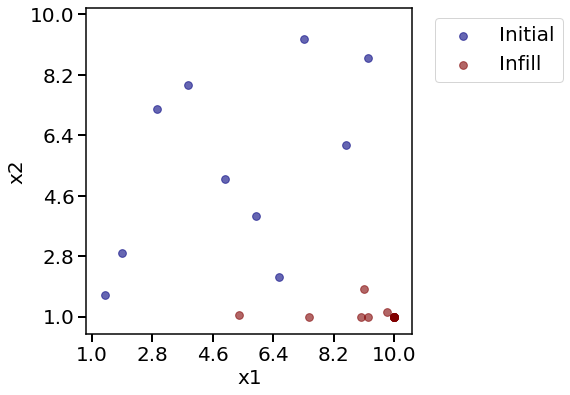

Comparing two plans:


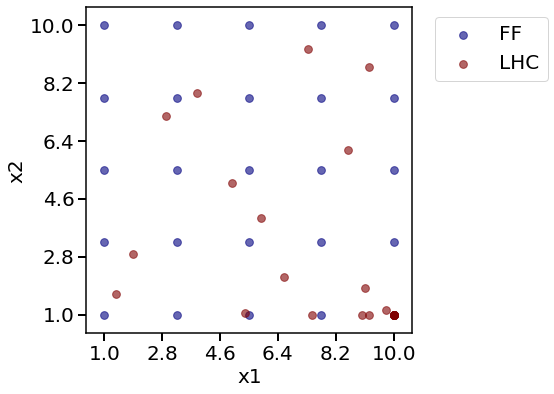

In [6]:
#%% plots 
# Check the sampling points
# Final lhc Sampling
print('LHC sampling points')
plotting.sampling_2d_exp(Exp_lhc)    
# Compare to full factorial
print('Comparing two plans:')
plotting.sampling_2d([Exp_ff.X, Exp_lhc.X], 
                     X_ranges = X_ranges,
                     design_names = ['FF', 'LHC'])

We can also visualize model predicted rates and error in heatmaps. The red colors indicates higher values and the blue colors indicates lower values.  

Objective function heatmap: 


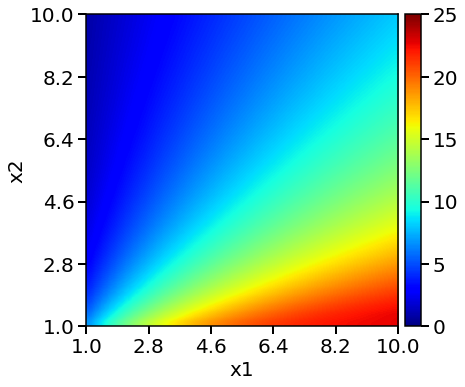

Full factorial model heatmap: 


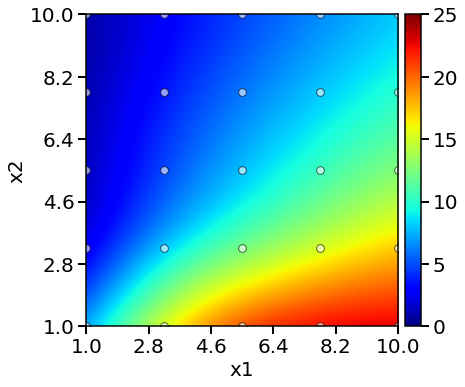

LHC model heatmap: 


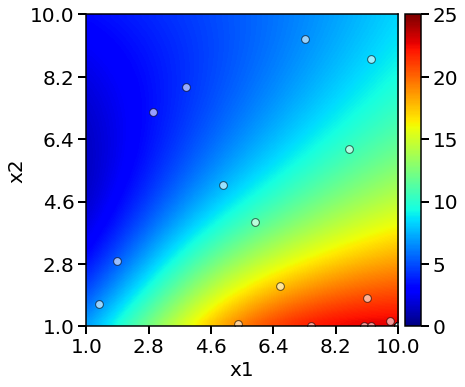

Full factorial model error heatmap: 


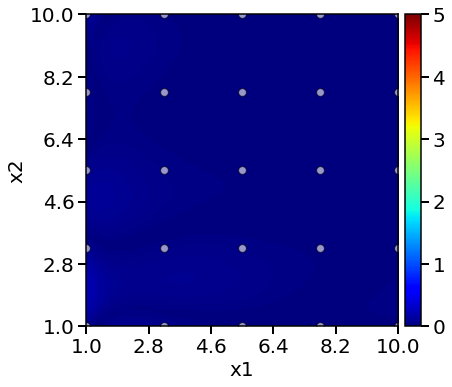

LHC model error heatmap: 


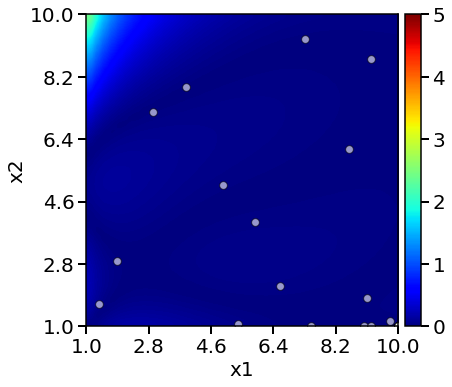

In [7]:
# Reponse heatmaps
# Objective function heatmap
print('Objective function heatmap: ')
plotting.objective_heatmap(objective_func, X_ranges, Y_real_range = [0, 25])
# full factorial heatmap
print('Full factorial model heatmap: ')
plotting.response_heatmap_exp(Exp_ff, Y_real_range = [0, 25])
# LHC heatmap
print('LHC model heatmap: ')
plotting.response_heatmap_exp(Exp_lhc, Y_real_range = [0, 25])


# full fatorial error heatmap
print('Full factorial model error heatmap: ')
plotting.response_heatmap_err_exp(Exp_ff, Y_real_range = [0, 5])
# LHC error heatmap
print('LHC model error heatmap: ')
plotting.response_heatmap_err_exp(Exp_lhc, Y_real_range = [0, 5])

The rates can also be plotted as response surfaces in 3D.

Objective function surface: 


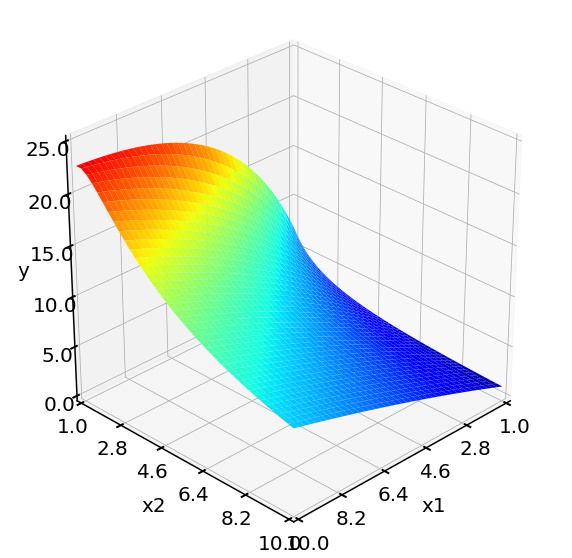

Full fatorial model surface: 


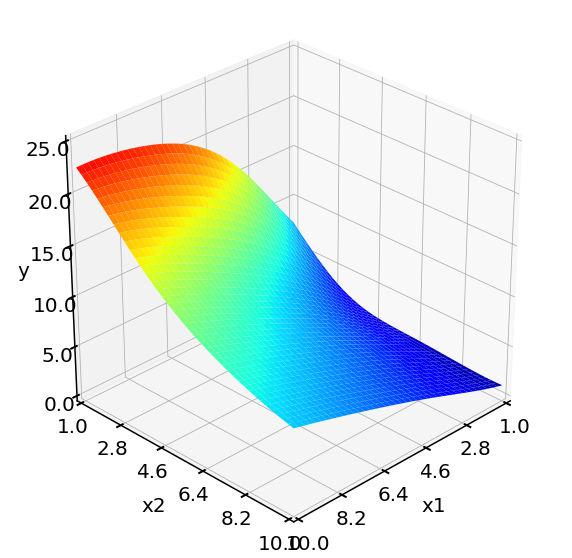

LHC model surface: 


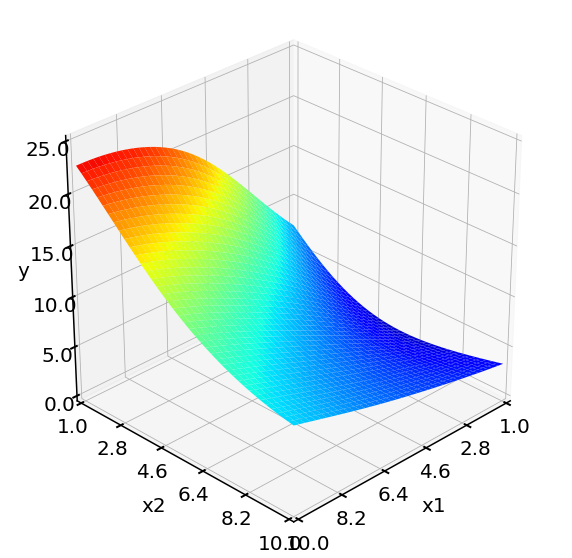

In [8]:
# Suface plots   
# Objective function surface plot  
print('Objective function surface: ')
plotting.objective_surface(objective_func, X_ranges, Y_real_range = [0, 25])
# full fatorial surface plot
print('Full fatorial model surface: ')
plotting.response_surface_exp(Exp_ff, Y_real_range = [0, 25])
# LHC surface plot
print('LHC model surface: ')
plotting.response_surface_exp(Exp_lhc, Y_real_range = [0, 25])

## 7. Export the optimum

Compare two plans in terms optimum discovered in each trial.

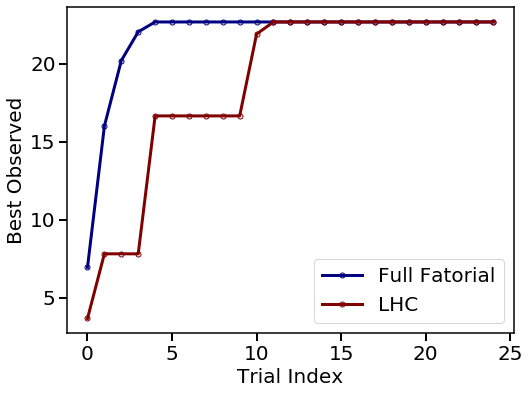

In [9]:
plotting.opt_per_trial([Exp_ff.Y_real, Exp_lhc.Y_real], 
                       design_names = ['Full Fatorial', 'LHC'])

Obtain the optimum from each method. 

In [10]:
# lhc optimum
y_opt_lhc, X_opt_lhc, index_opt_lhc = Exp_lhc.get_optim()
print('From LHC + Bayesian Optimization, ')
print('The best reponse is rate = {} at P = {}'.format(y_opt_lhc, X_opt_lhc))

# FF optimum
y_opt_ff, X_opt_ff, index_opt_ff = Exp_ff.get_optim()
print('From full factorial design, ')
print('The best reponse is rate = {} at P = {}'.format(y_opt_ff, X_opt_ff))

From LHC + Bayesian Optimization, 
The best reponse is rate = 22.675736961451246 at P = [10.  1.]
From full factorial design, 
The best reponse is rate = 22.675737380981445 at P = [10.  1.]


From above plots, we see both LHC + Bayesian Optimization and full factorial design locate the same optimum point in this 2D example. 